In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm
from ryu_tool import mytool

In [2]:
# 필요한 파일을 불러옵니다
price = pd.read_pickle("Data/allstock_reduced.pickle")
spx_mask = pd.read_pickle("Data/spx_mask.pickle")

rtn = price.pct_change(fill_method=None)

In [34]:
# 목적함수 Define
def obj_minvariance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [35]:
# weight를 담을 dataframe
weight = pd.DataFrame(index=rtn.index,
                      columns=rtn.columns)

In [36]:
pf_value = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
pf_rtn = {}

start_year = "2006" 
end_year =  "2020"

start_idx = pd.date_range(start_year,end_year, freq="QS")
end_idx = pd.date_range(start_year,end_year, freq="Q")

for i in tqdm(range(len(end_idx))):
    if i + 1 == len(end_idx): #마지막날은 weight계산할 필요가 없음...
        break
    
    # start~end의 주가를 보고 포폴 구성
    start = (start_idx[i] - pd.Timedelta(days=365)).strftime("%Y-%m") #2005-01
    end = (start_idx[i] - pd.Timedelta(days=1))             # 2005-12-31
    
    #print(f'{start}~{end} 주가를 보고 포트폴리오 구성')
    
    mask_sample = spx_mask.loc[:end].iloc[-1]
    universe = mask_sample.loc[~mask_sample.isna()].index # S&P500 구성종목을 가져옵니다
    rtn_sample = rtn.loc[start:end, universe]  # 이전 1년치 주가가 look back window
    cov_matrix = rtn_sample.cov()
    
    bounds = tuple((0,1) for _ in range(len(rtn_sample.columns))) # 제약조건 setting
    initial_weights = np.ones(len(rtn_sample.columns)) / len(rtn_sample.columns)
    
    result = minimize(obj_minvariance, 
                      initial_weights, 
                      args=(cov_matrix,),
                      method='SLSQP', 
                      constraints=constraints, 
                      bounds=bounds)
    
    min_variance_weights = result.x
    weight.loc[start_idx[i], universe] = min_variance_weights
    
    dollar_value = min_variance_weights * pf_value # 포트폴리오로 담을 각 주식의 달러가치
    # weight 계산한 당일 종가로 포트폴리오를 construct한다고 가정
    
    # 포트폴리오 성과 측정 기간
                             #2006-01-01
    start_date, end_date = start_idx[i].strftime("%Y-%m"), end_idx[i].strftime("%Y-%m")
    rtn_sample2 = rtn.loc[start_date:end_date, universe]
    
    for date in rtn_sample2.index:
        if date > rtn.index[-1]:
            break
        dollar_value = dollar_value * (1+rtn_sample2.loc[date]) # dollar value 변화를 update
        pf_value = dollar_value.sum()
        pf_rtn[date.strftime("%Y-%m-%d")] = pf_value

 98%|█████████▊| 55/56 [03:11<00:03,  3.48s/it]


In [37]:
rt = pd.Series(pf_rtn)
rt["2006-01-02"] = 1
r = rt.sort_index().pct_change().fillna(0)
r.index = pd.to_datetime(r.index)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


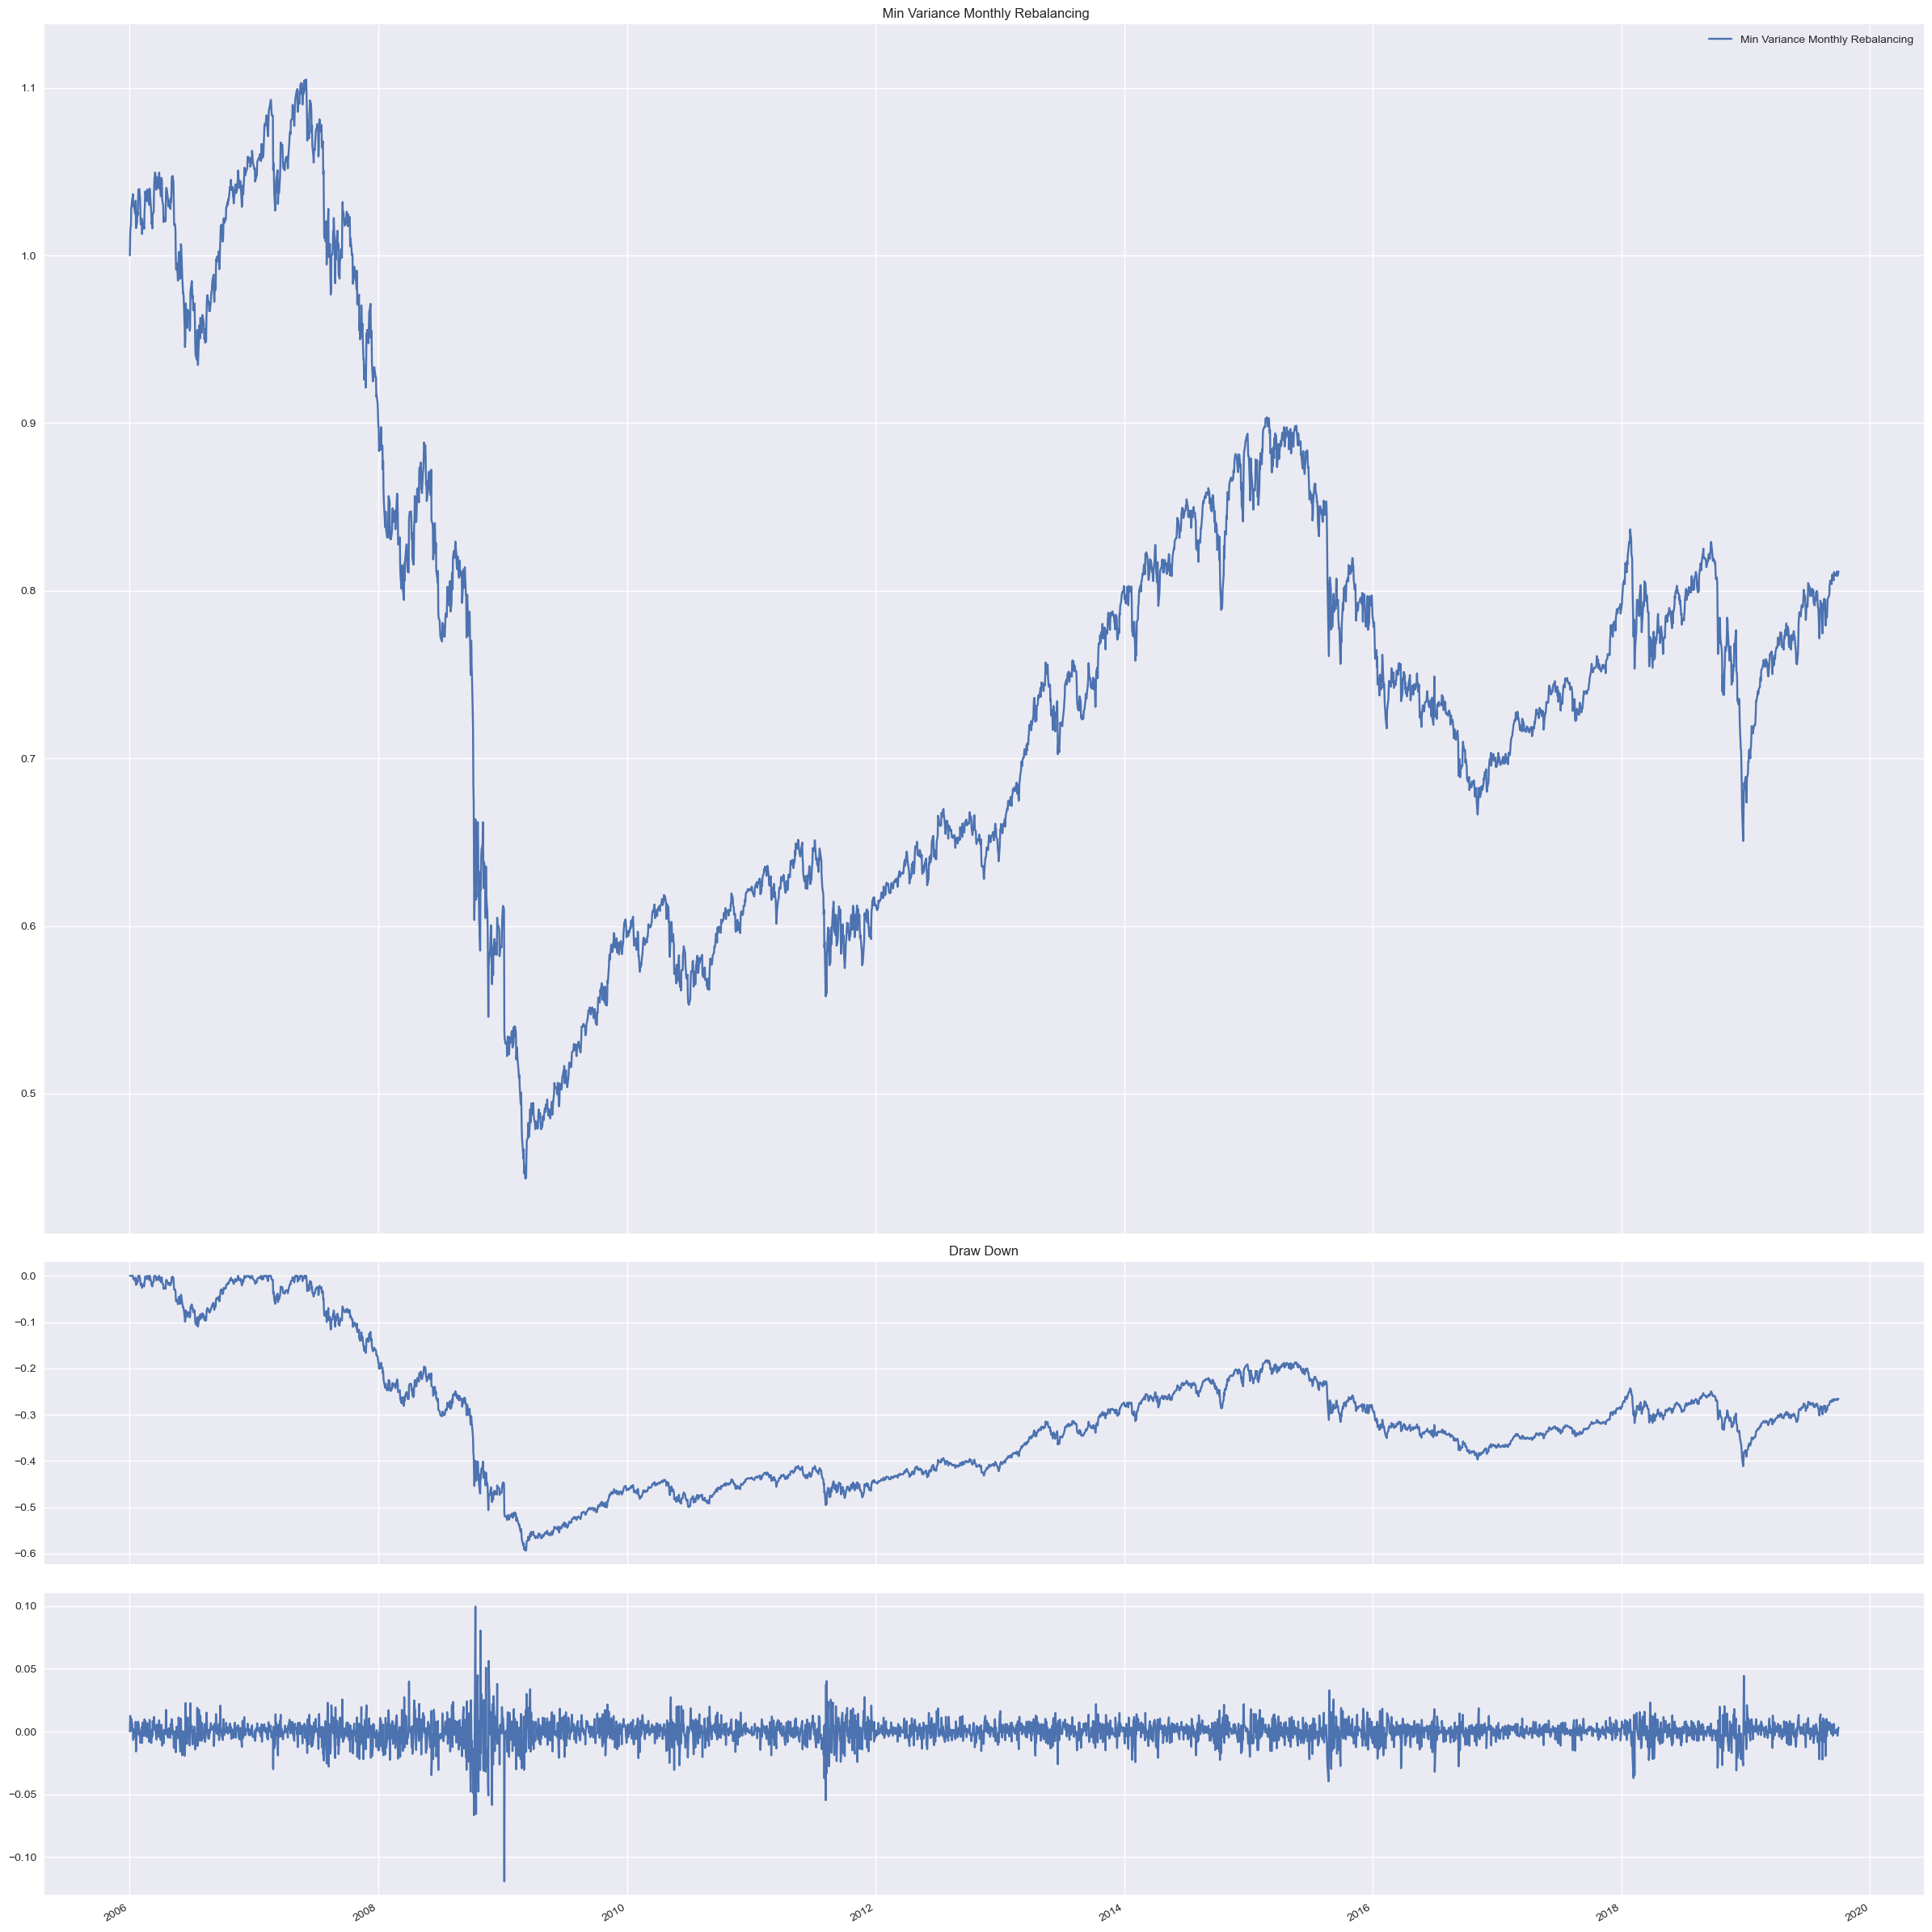

In [38]:
mytool.draw_return_result({"Min Variance Monthly Rebalancing" :r},
                          title="")

In [39]:
weight.dropna(axis=0, thresh=100).iloc[:50]

PERMNO,10225.0,14702.0,10942.0,38578.0,42083.0,50876.0,60442.0,82959.0,19502.0,75789.0,...,22976.0,17307.0,88182.0,17942.0,16581.0,86288.0,12476.0,82276.0,23569.0,84262.0
date,,,,,,,,,,,,,,,,,,,,,
2007-10-01,0.003666,0.000918,NaN,NaN,NaN,0.00418,0.001426,NaN,0.004772,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-04-01,0.002,0.002,NaN,NaN,NaN,0.002,0.002,NaN,0.002,0.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-01,0.004407,0.0,NaN,NaN,NaN,0.006168,0.0,NaN,0.009669,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-01,0.001433,0.0,NaN,NaN,NaN,0.007936,0.0,NaN,0.005384,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-04-01,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-07-01,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-10-01,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-04-01,0.0,0.0,NaN,NaN,NaN,0.005782,0.0,NaN,0.00363,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-07-01,0.0,0.0,NaN,NaN,NaN,0.009615,0.0,NaN,0.004176,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
pf_value = 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
pf_rtn = {}

start_year = "2006" 
end_year =  "2020"

start_idx = pd.date_range(start_year,end_year, freq="QS")
end_idx = pd.date_range(start_year,end_year, freq="Q")

for i in tqdm(range(len(end_idx))):
    if i + 1 == len(end_idx): #마지막날은 weight계산할 필요가 없음...
        break
    
    # start~end의 주가를 보고 포폴 구성
    start = (start_idx[i] - pd.Timedelta(days=365)).strftime("%Y-%m") #2005-01
    end = (start_idx[i] - pd.Timedelta(days=1))             # 2005-12-31
    
    #print(f'{start}~{end} 주가를 보고 포트폴리오 구성')
    
    mask_sample = spx_mask.loc[:end].iloc[-1]
    universe = mask_sample.loc[~mask_sample.isna()].index # S&P500 구성종목을 가져옵니다
    rtn_sample = rtn.loc[start:end, universe]  # 이전 1년치 주가가 look back window
    cov_matrix = rtn_sample.cov()

  4%|▎         | 2/56 [00:00<00:04, 10.97it/s]

0.0
-0.0
-0.0


 11%|█         | 6/56 [00:00<00:04, 10.92it/s]

-0.0
-0.0
-0.0


 14%|█▍        | 8/56 [00:00<00:04, 10.95it/s]

0.0
-0.0
0.0


c:\Users\user\anaconda3\lib\site-packages\numpy\linalg\linalg.py:2158: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
 21%|██▏       | 12/56 [00:01<00:04, 10.86it/s]

nan
0.0
-0.0


 25%|██▌       | 14/56 [00:01<00:04, 10.49it/s]

0.0
-0.0
-0.0


 32%|███▏      | 18/56 [00:01<00:03, 10.49it/s]

0.0
0.0
-0.0


 36%|███▌      | 20/56 [00:01<00:03, 10.61it/s]

-0.0
-0.0
0.0


 39%|███▉      | 22/56 [00:02<00:03, 10.40it/s]

-0.0
-0.0


 46%|████▋     | 26/56 [00:02<00:02, 10.25it/s]

0.0
0.0
-0.0


 50%|█████     | 28/56 [00:02<00:02, 10.33it/s]

0.0
0.0
0.0


 57%|█████▋    | 32/56 [00:03<00:02, 10.73it/s]

0.0
-0.0
-0.0


 61%|██████    | 34/56 [00:03<00:02, 10.45it/s]

-0.0
0.0
0.0


 68%|██████▊   | 38/56 [00:03<00:01, 10.44it/s]

0.0
0.0
-0.0


 71%|███████▏  | 40/56 [00:03<00:01, 10.58it/s]

-0.0
-0.0
-0.0


 79%|███████▊  | 44/56 [00:04<00:01, 10.54it/s]

0.0
-0.0
-0.0


 82%|████████▏ | 46/56 [00:04<00:00, 10.34it/s]

0.0
0.0
0.0


 89%|████████▉ | 50/56 [00:04<00:00, 10.50it/s]

-0.0
0.0
0.0


 96%|█████████▋| 54/56 [00:05<00:00, 11.58it/s]

0.0
0.0
-0.0
0.0


 98%|█████████▊| 55/56 [00:05<00:00, 10.68it/s]

-0.0
